## Machine Learning for Regression

In [2]:
%%capture
!wget -O laptops.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df_path = "laptops.csv"
df = pd.read_csv(df_path)
len(df)

2160

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df = df[['ram', 'storage', 'screen', 'final_price']]
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


In [7]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Data type: {df[col].dtype}")
    print(f"First 5 unique values: {df[col].dropna().unique()[:5]}")
    print(f"Number of unique values: {df[col].nunique()}")
    print(f"Missing values: {df[col].isnull().sum()} ({df[col].isnull().mean() * 100:.2f}%)")
    print(f"Top 5 most frequent values:\n{df[col].value_counts().head()}")
    print("-" * 50)

Column: ram
Data type: int64
First 5 unique values: [ 8 16 32 12  4]
Number of unique values: 9
Missing values: 0 (0.00%)
Top 5 most frequent values:
ram
16    928
8     817
32    301
4      68
64     25
Name: count, dtype: int64
--------------------------------------------------
Column: storage
Data type: int64
First 5 unique values: [ 512  256 1000   64  128]
Number of unique values: 12
Missing values: 0 (0.00%)
Top 5 most frequent values:
storage
512     941
1000    570
256     450
128      67
2000     42
Name: count, dtype: int64
--------------------------------------------------
Column: screen
Data type: float64
First 5 unique values: [15.6 17.3 14.  16.1 13.3]
Number of unique values: 29
Missing values: 4 (0.19%)
Top 5 most frequent values:
screen
15.6    1009
14.0     392
16.0     174
17.3     161
13.3     131
Name: count, dtype: int64
--------------------------------------------------
Column: final_price
Data type: float64
First 5 unique values: [1009.    299.    789.   1199.  

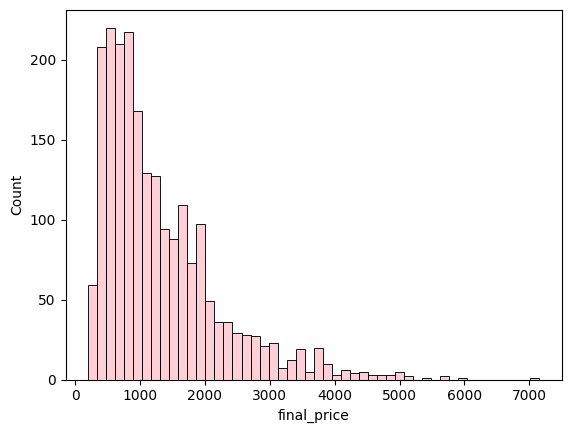

In [8]:
sns.histplot(df['final_price'], bins=50, color='pink')
plt.show()

## Q1. Missing values

In [9]:
skew_value = float(df.final_price.skew())
print(skew_value)

1.6495877663192549


In [10]:
skew_value = round(df.final_price.skew(), 2)
print(skew_value)

1.65


In [11]:
df.isnull().sum()[df.isnull().sum() > 0].index[0]

'screen'

## Q2. Median for RAM

In [14]:
df.ram.median()

np.float64(16.0)

In [15]:
ram_median = round(df.ram.median(), 2)
print(ram_median)

16.0


In [16]:
np.random.seed(42)

# Define the number of samples for train, validation, and test sets
num_samples = len(df)
num_val = int(num_samples * 0.2)  # 20% for validation
num_test = int(num_samples * 0.2)  # 20% for testing
num_train = num_samples - num_val - num_test  # Remaining 60% for training

# Shuffle the indices
idx = np.random.permutation(num_samples)

# Split the DataFrame into train, validation, and test sets
df_train = df.iloc[idx[:num_train]].reset_index(drop=True)
df_val = df.iloc[idx[num_train:num_train+num_val]].reset_index(drop=True)
df_test = df.iloc[idx[num_train+num_val:]].reset_index(drop=True)

# Separate the target column (final_price)
y_train = df_train['final_price'].values
y_val = df_val['final_price'].values
y_test = df_test['final_price'].values

# Drop the target column from the DataFrame
df_train = df_train.drop(columns=['final_price'])
df_val = df_val.drop(columns=['final_price'])
df_test = df_test.drop(columns=['final_price'])

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [18]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
def prepare_X(df, na_opt='zero'):
    df = df.copy()

    if na_opt == 'mean':
        df.fillna(df.mean(), inplace=True)
    else:
        df.fillna(0, inplace=True)
    X = df.values
    return X

In [20]:
# Prepare the training data
X_train = prepare_X(df_train, na_opt='zero')
w0, w = train_linear_regression(X_train, y_train)

# Prepare the validation data
X_val = prepare_X(df_val)

# Make predictions using the validation data
y_pred = w0 + X_val.dot(w)

# Calculate RMSE and round to 2 decimal places
score_0 = round(rmse(y_val, y_pred), 2)

print(score_0)

597.36


In [21]:
# Prepare the training data, filling missing values with the mean
X_train = prepare_X(df_train, na_opt='mean')
w0, w = train_linear_regression(X_train, y_train)

# Prepare the validation data
X_val = prepare_X(df_val)

# Make predictions using the validation data
y_pred = w0 + X_val.dot(w)

# Calculate RMSE and round to 2 decimal places
score_mean = round(rmse(y_val, y_pred), 2)

print(score_mean)

597.74


## Q3. Filling NAs

In [22]:
'With 0' if score_0 < score_mean else ('With mean' if score_0 > score_mean else 'Both are equally good')

'With 0'

## Q4. Regularization

In [23]:
def train_linear_regression_reg(X, y, r=0.001):
    # Adding bias term (column of ones) to the feature matrix
    bias_term = np.ones(X.shape[0])
    X = np.column_stack([bias_term, X])

    # Regularized normal equation: (X^T * X + r * I)^(-1) * X^T * y
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])  # L2 regularization term
    
    try:
        XTX_inv = np.linalg.inv(XTX)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix is singular and cannot be inverted.")

    # Calculating weights
    w_full = XTX_inv.dot(X.T).dot(y)
    
    # Returning the intercept and weights separately
    return w_full[0], w_full[1:]

In [24]:
# List of regularization parameters to test
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
score_list = []

# Iterate through the list of regularization parameters
for r in r_list:
    # Prepare training data with missing values filled as zero
    X_train = prepare_X(df_train, na_opt='zero')
    
    # Train the linear regression model with regularization
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    # Prepare validation data
    X_val = prepare_X(df_val)

    # Predict the target variable on the validation set
    y_pred = w0 + X_val.dot(w)

    # Append the RMSE to the score list, converted to an integer
    score_list.append(int(round(rmse(y_val, y_pred), 2)))

# Find the regularization parameter that gave the lowest RMSE
best_r = r_list[np.argmin(score_list)], score_list # 4. Regularization

print(best_r)

(0, [597, 597, 597, 597, 597, 597, 597])


## Q5. RMSE spread

In [30]:
score_list = []

for seed in range(10):
    np.random.seed(seed)  # Set random seed for reproducibility

    # Define dataset sizes for training, validation, and testing sets
    n = len(df)
    n_val = int(n * 0.2)  # 20% of the data for validation
    n_test = int(n * 0.2)  # 20% of the data for testing
    n_train = n - n_val - n_test  # Remaining 60% for training

    # Shuffle indices for splitting the dataset
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Split the dataset into training, validation, and test sets
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    # Separate the target variable (final_price) from each set
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    # Remove the target variable from the feature sets
    df_train = df_train.drop(columns=['final_price'])
    df_val = df_val.drop(columns=['final_price'])
    df_test = df_test.drop(columns=['final_price'])

    # Prepare feature matrix for training set (e.g., handling missing values)
    X_train = prepare_X(df_train, na_opt='zero')
    
    # Train the linear regression model
    w0, w = train_linear_regression(X_train, y_train)

    # Prepare feature matrix for validation set
    X_val = prepare_X(df_val)
    
    # Predict the target variable on validation set
    y_pred = w0 + X_val.dot(w)
    
    # Append the RMSE for this iteration to the score list
    score_list.append(rmse(y_val, y_pred))

# Calculate the standard deviation of RMSE scores and round it to 3 decimal places
std_rmse = round(np.std(score_list), 3)

# RMSE
print(f"Standard deviation of RMSE across different seeds: {std_rmse}")

Standard deviation of RMSE across different seeds: 29.176


In [31]:
np.random.seed(9)

n = len(df)
n_val = int(n * 0.2)  # 20% for validation
n_test = int(n * 0.2)  # 20% for testing
n_train = n - n_val - n_test  # Remaining 60% for training

idx = np.arange(n)
np.random.shuffle(idx)

# Split the dataset into training, validation, and test sets
df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

# Separate the target variable (final_price) from each set
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [32]:
# Concatenate training and validation datasets into one full training dataset, resetting index
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

# Concatenate target arrays for training and validation into one full target array
y_full_train = np.concatenate([y_train, y_val])

## Q6. RMSE on Test

In [33]:
# Prepare the full training dataset, filling missing values with zeros
X_full_train = prepare_X(df_full_train, na_opt='zero')

# Train the linear regression model with regularization (ridge regression)
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# Prepare the test dataset
X_test = prepare_X(df_test)

# Make predictions on the test set
y_pred = w0 + X_test.dot(w)

# Calculate and print the rounded RMSE on the test set
rmse_test = round(rmse(y_test, y_pred), 2)

# If converting RMSE to an integer is required, otherwise use the float
rmse_test_int = int(rmse_test) if rmse_test.is_integer() else rmse_test

print(f"Test set RMSE: {rmse_test_int:.2f}")

Test set RMSE: 608.61
